In [1]:
library(tidyverse)
library(cowplot)
library(plotly)
#setwd("C:/MyDisk/MDS/DSCI_532/grp_prjct/New/DSCI_532_Group114_SKEC")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




Warning message:
“Missing column names filled in: 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13]”
Parsed with column specification:
cols(
  YEAR = col_double(),
  Population = col_double(),
  X3 = col_logical(),
  X4 = col_logical(),
  X5 = col_logical(),
  X6 = col_logical(),
  X7 = col_logical(),
  X8 = col_logical(),
  X9 = col_logical(),
  X10 = col_logical(),
  X11 = col_logical(),
  X12 = col_logical(),
  X13 = col_logical()
)

Parsed with column specification:
cols(
  NEIGHBOURHOOD = col_character(),
  proportion = col_double()
)

Parsed with column specification:
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)

Joining, by = "YEAR"


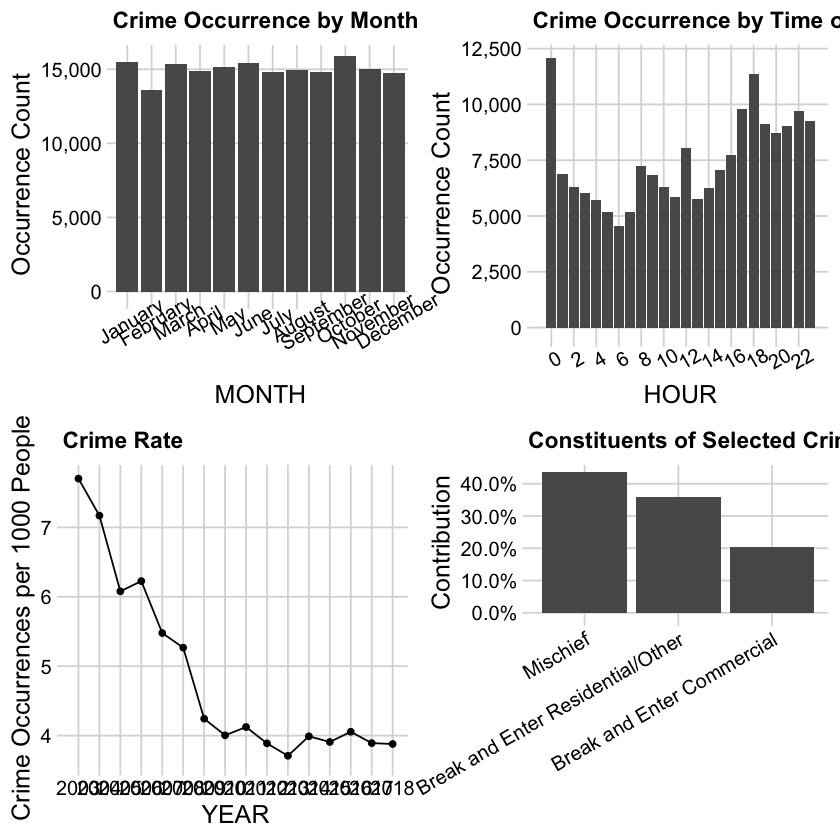

In [2]:

# Reading Vancouver City Population from 2001 to 2018
pop_yr <- read_csv("Data/Population_trend.csv")
pop_yr <- pop_yr %>% select(YEAR, Population)

# Reading each neighborhood's proportion of population to overall city's population
pop_prop <- read_csv("Data/population_proportion.csv")

# Reading Crime Data
mydata <- read_csv("Data/crimedata_csv_all_years.csv")

# Removing columns not needed & cleaning data
mydata <- mydata %>% 
    filter(!(X==0 | Y==0 | is.na(NEIGHBOURHOOD))) %>%
    select(-DAY, -MINUTE, -HUNDRED_BLOCK)

# Excluding Year 2019 because the data is till Oct only whereas other
# years have full data
mydata <- mydata %>% 
    filter(YEAR!=2019)

# Relacing Stanley Park with West End because its a subset
# Relacing Musqueam with Marpole because its a subset
# Renaming others
mydata <- mydata %>%
    mutate(NEIGHBOURHOOD = case_when(
            NEIGHBOURHOOD=='Stanley Park' ~ 'West End',
            NEIGHBOURHOOD=='Musqueam' ~ 'Marpole',
            NEIGHBOURHOOD=='Arbutus Ridge' ~ 'Arbutus-Ridge',
            NEIGHBOURHOOD=='Central Business District' ~ 'Downtown',
            TRUE ~ NEIGHBOURHOOD
        ), TYPE = case_when(
            TYPE=='Vehicle Collision or Pedestrian Struck (with Fatality)' ~ 'Vehicle Collision or Pedestrian Struck',
            TYPE=='Vehicle Collision or Pedestrian Struck (with Injury)' ~ 'Vehicle Collision or Pedestrian Struck',
            TRUE ~ TYPE 
        ))

pop_prop <- pop_prop %>%
    mutate(NEIGHBOURHOOD = case_when(
            NEIGHBOURHOOD=='Stanley Park' ~ 'West End',
            NEIGHBOURHOOD=='Musqueam' ~ 'Marpole',
            NEIGHBOURHOOD=='Arbutus Ridge' ~ 'Arbutus-Ridge',
            NEIGHBOURHOOD=='Central Business District' ~ 'Downtown',
            TRUE ~ NEIGHBOURHOOD
        ))


# type_lst <- unique(mydata$TYPE)
# ngbrhd_lst <- unique(mydata$NEIGHBOURHOOD)
# yr_lst <- unique(mydata$YEAR)
make_charts <- function(type_lst, ngbrhd_lst, yr_lst){
    df <- mydata %>% 
        filter(TYPE %in% type_lst & NEIGHBOURHOOD %in% ngbrhd_lst & YEAR %in% yr_lst)

    MOY <- df %>% 
        group_by(MONTH) %>%
        summarise(N = n()) %>%
        arrange(MONTH)
    MOY <- MOY %>% 
        mutate(MONTH_NAME = c('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'))

    TOD <- df %>% 
        group_by(HOUR) %>%
        summarise(N = n()) %>%
        arrange(HOUR)

    type_crimes <- df %>% 
        group_by(TYPE) %>%
        summarise(N = n()) %>%
        arrange(-N)
    type_crimes <- type_crimes %>% mutate(contri = N/sum(type_crimes$N))

    crime_rate <- df %>% 
        group_by(YEAR) %>%
        summarise(N = n()) %>%
        arrange(YEAR)



    # Adding population data to plot crime rate
    required_prop <-pop_prop %>% filter(NEIGHBOURHOOD %in% ngbrhd_lst) %>% pull(proportion) %>% sum()
    pop_yr <- pop_yr %>% filter(YEAR %in% yr_lst) %>% mutate(Population = Population*required_prop)

    crime_rate <- inner_join(crime_rate, pop_yr)
    crime_rate <- crime_rate %>% mutate(rate = (N/Population)*1000)


    chart1 <- ggplot(MOY, aes(x=reorder(MONTH_NAME, MONTH), y=N)) + 
        geom_bar(stat = "identity") + 
        labs(x='MONTH', y= 'Occurrence Count') + 
        scale_y_continuous(labels = scales::comma) + 
        ggtitle("Crime Occurrence by Month") + 
        theme_minimal_grid() + 
        theme(
            text = element_text(size = 12),
            axis.title.x = element_text(size = 15),
            axis.title.y = element_text(size = 15),
            axis.text.x = element_text(angle = 30, hjust = 0.5))

    chart2 <- ggplot(TOD, aes(x=HOUR, y=N)) + 
        geom_bar(stat = "identity") + 
        labs(x='HOUR', y= 'Occurrence Count') + 
        scale_y_continuous(labels = scales::comma) +
        scale_x_continuous(breaks = seq(0, 23, 2)) +
        ggtitle("Crime Occurrence by Time of Day") + 
        theme_minimal_grid() + 
        theme(
            text = element_text(size = 12),
            axis.title.x = element_text(size = 15),
            axis.title.y = element_text(size = 15),
            axis.text.x = element_text(angle = 30, hjust = 0.5))


    chart3 <- ggplot(crime_rate, aes(x=YEAR, y=rate)) + 
        geom_point() + 
        geom_line() + 
        labs(x='YEAR', y= 'Crime Occurrences per 1000 People') + 
        scale_x_continuous(breaks = seq(min(crime_rate$YEAR), max(crime_rate$YEAR), 1)) +
        ggtitle("Crime Rate") + 
        theme_minimal_grid() + 
        theme(
            text = element_text(size = 12),
            axis.title.x = element_text(size = 15),
            axis.title.y = element_text(size = 15))

    chart4 <- ggplot(type_crimes, aes(x=reorder(TYPE, -contri), y=contri)) + 
        geom_bar(stat = "identity") + 
        labs(x='', y= 'Contribution') + 
        scale_y_continuous(labels = scales::percent) +
        ggtitle("Constituents of Selected Crimes") + 
        theme_minimal_grid() + 
        theme(
            text = element_text(size = 12),
            axis.title.x = element_text(size = 15),
            axis.title.y = element_text(size = 15),
            axis.text.x = element_text(angle = 30, hjust = 1))

    return(plot_grid(chart1, chart2, chart3, chart4))

}


type_lst <- unique(mydata$TYPE)
ngbrhd_lst <- unique(mydata$NEIGHBOURHOOD)
yr_lst <- unique(mydata$YEAR)

make_charts(type_lst[1:3], ngbrhd_lst, yr_lst)



In [2]:
pop_yr <- read_csv("Data/Population_trend.csv")
pop_yr <- pop_yr %>% select(YEAR, Population)



Warning message:
“Missing column names filled in: 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13]”
Parsed with column specification:
cols(
  YEAR = col_double(),
  Population = col_double(),
  X3 = col_logical(),
  X4 = col_logical(),
  X5 = col_logical(),
  X6 = col_logical(),
  X7 = col_logical(),
  X8 = col_logical(),
  X9 = col_logical(),
  X10 = col_logical(),
  X11 = col_logical(),
  X12 = col_logical(),
  X13 = col_logical()
)



In [13]:
pop_yr <- read_csv("Data/Population_trend.csv")
pop_yr <- pop_yr %>% select(YEAR, Population)

Warning message:
“Missing column names filled in: 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13]”
Parsed with column specification:
cols(
  YEAR = col_double(),
  Population = col_double(),
  X3 = col_logical(),
  X4 = col_logical(),
  X5 = col_logical(),
  X6 = col_logical(),
  X7 = col_logical(),
  X8 = col_logical(),
  X9 = col_logical(),
  X10 = col_logical(),
  X11 = col_logical(),
  X12 = col_logical(),
  X13 = col_logical()
)



In [14]:
pop_yr

YEAR,Population
<dbl>,<dbl>
2001,2093125
2002,2115651
2003,2132984
2004,2147959
2005,2173374
2006,2198338
2007,2232063
2008,2261986
2009,2303480
